In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functions import loader, splt, fitter, stats, grouper
import matplotlib.pyplot as plt

savedir = "G01/"

In [3]:
all_data = loader.load_data()
data = loader.remove_duplicates( all_data,
    lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
    lambda d: d['runned_replicas']
)
len( data )

135

In [4]:
for d in data:
    x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    d['fits'] = fitter.fits( x, y, d, threshold=0.5, plot=False )
    d['np_std'] = np.std( d['chunks'], ddof=1 ) / d['side'] / d['side']

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [5]:
filtered_data = data[ np.vectorize( lambda d: ( d['gamma'] in [0.4, 0.8, 1.2, 1.6] ) and ( d['defects_frac'] in [0.05, 0.1, 0.2] ) )(data) ]

In [15]:
from functions import CEfitter

to_use = lambda d: d['fits']['Gauss']['pars'][2]
# to_use = lambda d: d['np_std']


grouped_data = grouper.extract_xy( filtered_data, ['dep_polymers', 'defects_frac', 'gamma'], lambda d: d['side'], to_use )

grouped_data = grouped_data[ np.vectorize( lambda g : len( g['x'] ) > 2 )( grouped_data ) ]

for g in grouped_data:
    g['B'], logx, logyB = CEfitter.estimate_B( g['x'] , g['y'] )
    g['oneovernu'], g['shift'] = CEfitter.estimate_oneovernu( logx, logyB )

4 iter.
4 iter.
4 iter.
3 iter.
3 iter.
3 iter.
4 iter.
3 iter.
3 iter.
4 iter.
3 iter.
4 iter.
4 iter.
4 iter.
4 iter.
4 iter.
4 iter.
4 iter.


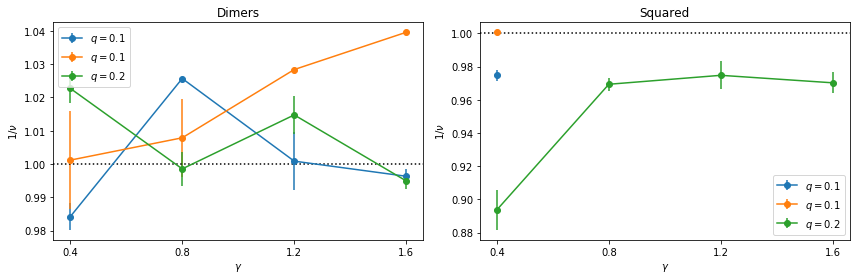

In [7]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        grouped_data[d]['oneovernu']
    ],
    lambda it, l: [
        { 'label': fr"$q = {l:.1f}$", 'ls': '-', 'marker': 'o' }
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$1/\nu$" ),
        splt.hline( 1 )
    )
)

plt.tight_layout()
plt.savefig( savedir + '/oneovernu.pdf' )
plt.savefig( savedir + '/oneovernu.png' )

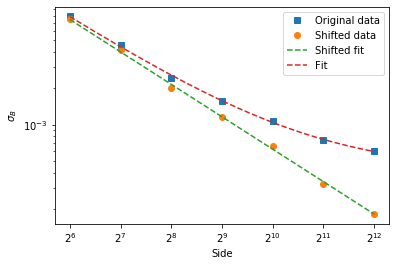

In [28]:
plt.loglog( grouped_data[0]['x'], grouped_data[0]['y'], 's', label="Original data", basex = 2, basey = 10 )
plt.plot( grouped_data[0]['x'], grouped_data[0]['y'] - grouped_data[0]['B'], 'o', label="Shifted data" )

x = np.logspace( np.log2( np.min(  grouped_data[0]['x'] ) ), np.log2( np.max(  grouped_data[0]['x'] ) ), 1000, base = 2 )
plt.plot( x, np.array( x ) ** ( - grouped_data[0]['oneovernu'].n ) * 2 ** ( grouped_data[0]['shift'].n ), '--', label = "Shifted fit" )
plt.plot( x, np.array( x ) ** ( - grouped_data[0]['oneovernu'].n ) * 2 ** ( grouped_data[0]['shift'].n ) + grouped_data[0]['B'], '--', label = "Fit" )

plt.legend()

plt.xlabel( "Side" )
plt.ylabel( fr"$\sigma_B$" )

plt.savefig( savedir + "fit.pdf")
plt.savefig( savedir + "fit.png")